# W14 Lab Exercise
This is the lab exercise for MIS590: Information Retrieval. </br>
In this lab, you will gain the following experience:</br>
- Understand how to load an open-source large language model (LLM)
- Inference with the LLM.
</br>

**Note:** When you see a pencil icon ✏️ in this notebook, it's time for you to code or answer the question!

# 1. Preliminaries
## 1.1 Install and Import Libraries

In [1]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [2]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

In [3]:
!pip install tqdm

In [4]:
import pandas as pd
import json
import random
from tqdm import tqdm
import torch
from unsloth import FastLanguageModel
from transformers import TextStreamer

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


## 1.2 Model Setup

In [5]:
max_seq_length = 2048
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models unsloth support for 4x faster downloading and no out-of-memory errors ensured.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 2x faster
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # 4bit for 405b!
    "unsloth/Mistral-Small-Instruct-2409",     # Mistral 22b 2x faster
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster

    "unsloth/Llama-3.2-1B-bnb-4bit",           # Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",
] # More models at https://huggingface.co/unsloth

# Load the selected model
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2024.12.4: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

In [6]:
# Show the model detail
FastLanguageModel.for_inference(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096, padding_idx=128004)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaExtendedRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): L

### ✏️ Observe the results above and discuss the following:
- Explain the parameters we passed to ``FastLanguageModel.from_pretrained``

Answer:
- The parameters passed to FastLanguageModel.from_pretrained are:
    - model_name: The name of the model to load. In this case, we loaded the "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit" model.
    - max_seq_length: The maximum sequence length for the model. In this case, the maximum sequence length is set to 2048.
    - dtype: The data type to use for the model. In this case, the data type is set to None for auto-detection.
    - load_in_4bit: A boolean value indicating whether to use 4-bit quantization to reduce memory usage. In this case, it is set to True and the GPU memory usage is reduced.

# 2. Inference with LLM
## 2.1 Prompt Construction

In [7]:
# Prior research suggests that role-playing with LLMs can enhance text generation performance
chatbot_role = "You are a linguistic expert specialized in extracting temporal knowledge from text."

# The instruction provided to the LLM, explaining how to complete the task
instruction = """In the following, you will be given an article. Extract the temporal knowledge from text and format as a quadruple (head entity; relation; tail entity; timestamp). Extract every complete quadruple you can find from the article. Make sure no element in the quadruple is missing. Do not output anything else other than the quadruple."""

# A one-shot setting
examplar = """Following is an example:
The inauguration of Joe Biden as the 46th president of the United States took place on Wednesday, January 20, 2021.
Temporal knowledge quadruple: (Joe Biden; president_of; The United States;  2021/01/20), (Joe Biden; deliver; United States presidential inauguration; 2021/01/20)"""

# Formatting the prompt
prompt = """Instruction: {0}
Example: {1}

Article: {2}"""

In [8]:
article = """
The 96th Academy Awards ceremony, presented by the Academy of Motion Picture Arts and Sciences (AMPAS), took place on March 10, 2024, at the Dolby Theatre in Hollywood, Los Angeles.
"""

complete_prompt = prompt.format(instruction, examplar, article)
# Set up the chat scenario with roles
messages = [
    {"role": "system", "content": chatbot_role},
    {"role": "user", "content": complete_prompt}
]

inputs = tokenizer.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,  # Must add for generation
    return_tensors="pt",
).to("cuda")
# Create an attention mask to avoid warning
attention_mask = torch.ones_like(inputs).to("cuda")

# Get the length of the input prompt
len_input = inputs.shape[1]

# Generate the response
generated_ids = model.generate(
    input_ids=inputs,
    max_new_tokens=100,
    use_cache=True,
    temperature=0.7,
    min_p=0.1,
    attention_mask=attention_mask
)

# Extract only the generated tokens (excluding the prompt)
generated_tokens = generated_ids[0][len_input:]

# Decode the generated tokens to get the model's output
output_string = tokenizer.decode(generated_tokens, skip_special_tokens=True)
print(output_string)

(96th Academy Awards ceremony; took_place; Dolby Theatre in Hollywood, Los Angeles; 2024/03/10)


### ✏️ Observe the results above and discuss the following:
- Do you think the LLM did a good job? Why?
- Can we conclude that LLMs are capable of inferring temporal relations from text based on this example?

Input: The 96th Academy Awards ceremony, presented by the Academy of Motion Picture Arts and Sciences (AMPAS), took place on March 10, 2024, at the Dolby Theatre in Hollywood, Los Angeles.
Extract: (96th Academy Awards ceremony; took_place; Dolby Theatre in Hollywood, Los Angeles; 2024/03/10)

Answer:
- From the generated output, the LLM did a good job in extracting the temporal knowledge from the text. It successfully identified the head entity (96th Academy Awards ceremony), the relation (took_place), the tail entity (Dolby Theatre in Hollywood, Los Angeles), and the timestamp (2024/03/10). So it did a good job in this case.
- But we cannot conclude that LLMs are capable of inferring temporal relations from a text based on this example. This is because the LLM may do "extracting" the text rather than "inferring." We still need more complex reasoning tests to conclude that LLMs are capable of inferring temporal relations from text instead of just extracting them.

# Assignment 4
## 1. Discussion Questions
Answer the discussion questions above (those with ✏️ icon).
## 2. LLM-Based Sentiment Analysis
Let's try using LLMs for sentiment analysis task!
- **Dataset Preparation:**
  - Obtain the [IMDb Movie Reviews Dataset](https://paperswithcode.com/dataset/imdb-movie-reviews).
  - Randomly select 50 movie reviews from this dataset to form your sample set for this assignment.
- Prompt Engineering and Sentiment Analysis:
  - Carefully design a prompt to be used with an LLM (like the one you experimented with earlier) to analyze the sentiment expressed in each movie review within your sample set.
  - Experiment with different prompt strategies and settings to achieve optimal performance in sentiment classification.
  - The goal is to classify each review as having either positive or negative sentiment.
- Evaluation:
  - Calculate the following evaluation metrics to assess the performance of your LLM-based sentiment analysis system: **Accuracy**, **Precision**, and **Recall**.
  - Analyze the results, comparing the performance of different prompting strategies if you have tried any.

In [ ]:
import os

# Create dataset
positive_txt_dir = './aclImdb/test/pos/'
negative_txt_dir = './aclImdb/test/neg/'

# Randomly select 25 positive and 25 negative reviews
positive_reviews = random.sample(os.listdir(positive_txt_dir), 25)
negative_reviews = random.sample(os.listdir(negative_txt_dir), 25)

display(positive_reviews[:5], negative_reviews[:5])

['11743_9.txt', '9399_10.txt', '4282_7.txt', '10822_8.txt', '2089_10.txt']

['5906_2.txt', '2825_3.txt', '5641_1.txt', '9332_3.txt', '3319_1.txt']

In [ ]:
# Recreat a dataframe of the selected reviews
reviews = pd.DataFrame(columns=['review', 'sentiment'])

for review in positive_reviews:
    with open(positive_txt_dir + review, 'r') as file:
        reviews = pd.concat([reviews, pd.DataFrame({'review': [file.read()], 'sentiment': ['positive']})])

for review in negative_reviews:
    with open(negative_txt_dir + review, 'r') as file:
        reviews = pd.concat([reviews, pd.DataFrame({'review': [file.read()], 'sentiment': ['negative']})])

# Shuffle the reviews
reviews = reviews.sample(frac=1).reset_index(drop=True)

reviews.to_csv('movie_reviews.csv', index=False)

reviews.head()

,review,sentiment
0,"You don't review James Bond movies, you evalua...",positive
1,I can't believe that there are people out ther...,negative
2,This is definitely the worst vampire flicks of...,negative
3,This film is worth seeing since it is a classi...,negative
4,My Architect is a great film about Nathaniel K...,positive


In [9]:
reviews = pd.read_csv('movie_reviews.csv')

In [12]:
def predict_sentiment(
    review: str,
    system_prompt: str = """## Sentiment Analysis of Movie Review

- **YOU ARE** a **SENTIMENT ANALYSIS EXPERT** skilled in analyzing text sentiment with accuracy.

## Task Description

- **YOUR TASK IS** to **ANALYZE** the sentiment of the provided movie review text and **OUTPUT ONLY** one of two results:
   - **'positive'**
   - **'negative'**

### Action Steps
1. **READ** the given movie review carefully.
2. **DETERMINE** whether the sentiment expressed in the review is **positive** or **negative**.
3. **OUTPUT** the sentiment as a single word: either **'positive'** or **'negative'**.
   - **YOU MUST NOT** include any explanations, additional words, or formatting.
   - **OUTPUT FORMAT**: Plain text.

## IMPORTANT
- **ENSURE** the output strictly follows the format of a single word: **'positive'** or **'negative'**.
- **DO NOT** include any other text, comments, or explanations."""
) -> str:
    """
    Predict the sentiment of a movie review using an LLM.
    :param system_prompt: The system prompt for the LLM.
    :param review: The movie review text.
    :return: The predicted sentiment (positive or negative).
    """
    # Set up the chat scenario with roles
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": review}
    ]

    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,  # Must add for generation
        return_tensors="pt",
    ).to("cuda")
    # Create an attention mask to avoid warning
    attention_mask = torch.ones_like(inputs).to("cuda")

    # Get the length of the input prompt
    len_input = inputs.shape[1]

    # Generate the response
    generated_ids = model.generate(
        input_ids=inputs,
        max_new_tokens=100,
        use_cache=True,
        temperature=0.7,
        min_p=0.1,
        attention_mask=attention_mask
    )

    # Extract only the generated tokens (excluding the prompt)
    generated_tokens = generated_ids[0][len_input:]

    # Decode the generated tokens to get the model's output
    output_string = tokenizer.decode(generated_tokens, skip_special_tokens=True)

    return output_string

# Test the predict_sentiment function
predict_sentiment(reviews['review'][0])

'positive'

In [13]:
# Calculate the sentiment for each review
predicted_sentiments = []

for review in tqdm(reviews['review']):
    predicted_sentiments.append(predict_sentiment(review))

predicted_sentiments[:5]

100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


['positive', 'negative', 'negative', 'negative', 'positive']

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def compute_metrics(
    reviews: pd.DataFrame,
    predicted_sentiments: list
) -> dict:
    """
    Compute evaluation metrics for sentiment analysis.
    :param reviews:
    :param predicted_sentiments:
    :return:
    """
    # Calculate the true sentiment labels
    true_sentiments = reviews['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).tolist()

    # Convert the predicted sentiments to binary labels
    predicted_labels = [1 if 'positive' in sentiment.lower() else 0 for sentiment in predicted_sentiments]

    # Calculate the evaluation metrics
    accuracy = accuracy_score(true_sentiments, predicted_labels)
    precision = precision_score(true_sentiments, predicted_labels)
    recall = recall_score(true_sentiments, predicted_labels)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall
    }

# Compute the evaluation metrics
metrics = compute_metrics(reviews, predicted_sentiments)

# Display the evaluation metrics
print(f'Accuracy: {metrics["accuracy"]}')
print(f'Precision: {metrics["precision"]}')
print(f'Recall: {metrics["recall"]}')

Accuracy: 0.92
Precision: 0.8888888888888888
Recall: 0.96


## Try across different prompts

In [34]:
prompt_sets = [
    ## Role-Based Expert Prompt (Detailed Structured Task)
    """## Sentiment Analysis of Movie Review

    - **YOU ARE** a **SENTIMENT ANALYSIS EXPERT** with extensive experience in text sentiment classification.

    ## Task Description
    - **YOUR TASK IS** to analyze the sentiment of the provided movie review and **OUTPUT ONLY** one of the following:
       - 'positive'
       - 'negative'

    ### Action Steps:
    1. **READ** the movie review carefully.
    2. **CLASSIFY** the sentiment as either positive or negative.
    3. **OUTPUT** only the word 'positive' or 'negative'.
       - **NO ADDITIONAL TEXT OR FORMATTING**.

    ## IMPORTANT
    - **FORMAT**: Output a single word only.
    - **STRICT RULE**: Do not provide any explanations, comments, or extra formatting.""",

    ## Minimalist Prompt
    """Analyze the following movie review and classify the sentiment.
    Respond with **one word only**: 'positive' or 'negative'.
    Do not include explanations, additional text, or formatting.""",

    ## Process-Oriented Prompt
    """## Sentiment Analysis Task

    Follow these steps carefully:
    1. **Read** the provided movie review.
    2. **Determine** if the sentiment is **positive** or **negative**.
    3. **Output** the result as a single word: 'positive' or 'negative'.

    ## Output Rules:
    - **FORMAT**: One word only.
    - **NO ADDITIONAL COMMENTS**: Do not include explanations, formatting, or extra words.""",

    ## Constraint-Focused Prompt
    """Your task is to classify the sentiment of the given movie review.

    **Output ONLY** one of the following:
       - 'positive'
       - 'negative'

    **RULES**:
    - Your output **MUST BE** a single word.
    - Do **NOT** include explanations, comments, or any extra text.""",

    ## Question-Driven Prompt
    """Is the sentiment of the following movie review **positive** or **negative**?
    Provide your answer in **one word only**:
       - 'positive'
       - 'negative'

    **IMPORTANT**:
    - Do not include explanations, comments, or any additional words."""
]

# Result dataframe
total_metrics = pd.DataFrame(columns=['prompt', 'accuracy', 'precision', 'recall'])

for prompt in prompt_sets:
    predicted_sentiments = []

    for review in tqdm(reviews['review']):
        predicted_sentiments.append(predict_sentiment(review, prompt))

    metrics = compute_metrics(reviews, predicted_sentiments)
    total_metrics = pd.concat([total_metrics, pd.DataFrame({'prompt': [prompt], 'accuracy': [metrics['accuracy']], 'precision': [metrics['precision']], 'recall': [metrics['recall']]})])

total_metrics


100%|██████████| 50/50 [00:48<00:00,  1.03it/s]
<ipython-input-34-0e9b862d2d67>:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total_metrics = pd.concat([total_metrics, pd.DataFrame({'prompt': [prompt], 'accuracy': [metrics['accuracy']], 'precision': [metrics['precision']], 'recall': [metrics['recall']]})])
100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


,prompt,accuracy,precision,recall
0,## Sentiment Analysis of Movie Review\n \n ...,0.80,0.894737,0.68
0,Analyze the following movie review and classif...,0.92,0.888889,0.96
0,## Sentiment Analysis Task\n\n Follow these...,0.88,0.952381,0.80
0,Your task is to classify the sentiment of the ...,0.94,0.923077,0.96
0,Is the sentiment of the following movie review...,0.92,0.888889,0.96


In [35]:
# F1-score
total_metrics['f1_score'] = 2 * (total_metrics['precision'] * total_metrics['recall']) / (total_metrics['precision'] + total_metrics['recall'])

total_metrics

,prompt,accuracy,precision,recall,f1_score
0,## Sentiment Analysis of Movie Review\n \n ...,0.80,0.894737,0.68,0.772727
0,Analyze the following movie review and classif...,0.92,0.888889,0.96,0.923077
0,## Sentiment Analysis Task\n\n Follow these...,0.88,0.952381,0.80,0.869565
0,Your task is to classify the sentiment of the ...,0.94,0.923077,0.96,0.941176
0,Is the sentiment of the following movie review...,0.92,0.888889,0.96,0.923077


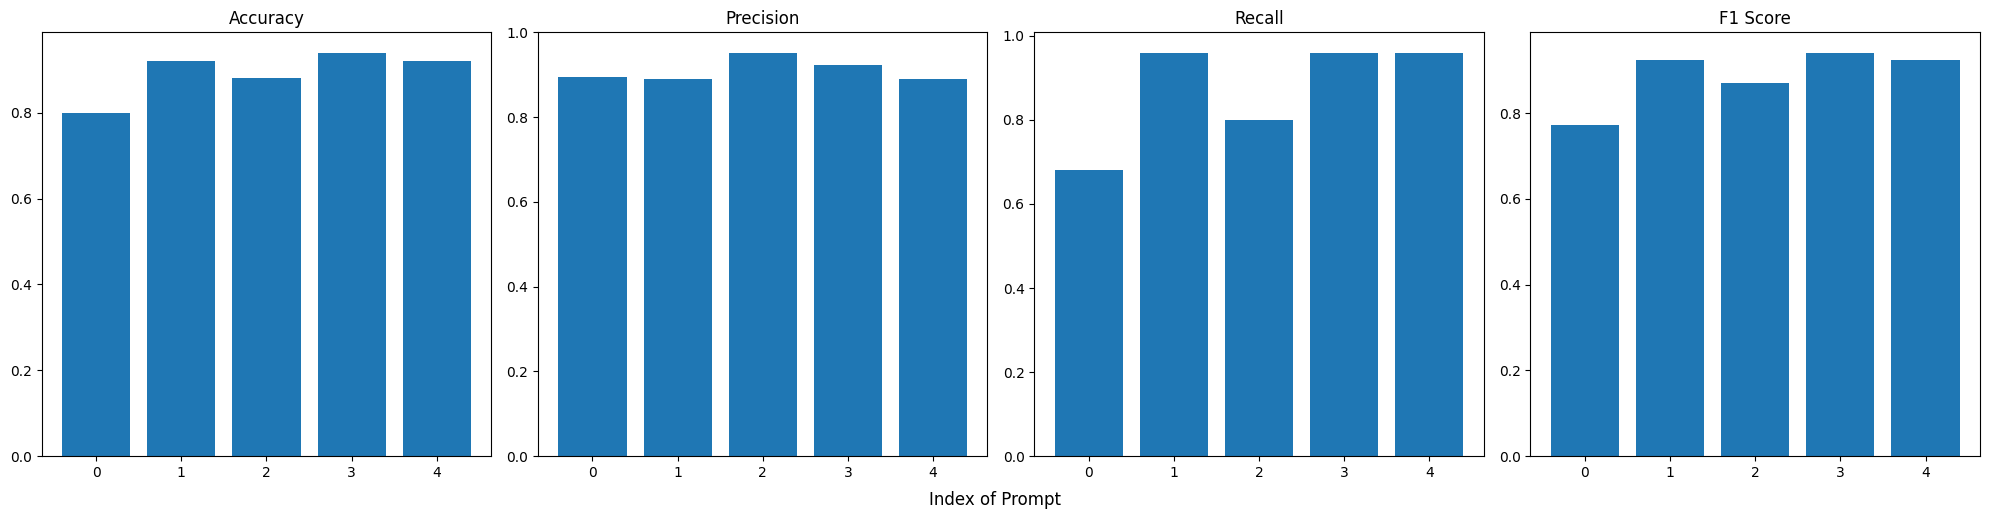

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# Use the index of the prompts as x-axis labels
x = range(len(total_metrics))  # Index as x-axis labels
indices = list(range(len(total_metrics['prompt'])))  # Numeric indices for labels

# Accuracy plot
ax[0].bar(x, total_metrics['accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xticks(x)
ax[0].set_xticklabels(indices, rotation=0)

# Precision plot
ax[1].bar(x, total_metrics['precision'])
ax[1].set_title('Precision')
ax[1].set_xticks(x)
ax[1].set_xticklabels(indices, rotation=0)

# Recall plot
ax[2].bar(x, total_metrics['recall'])
ax[2].set_title('Recall')
ax[2].set_xticks(x)
ax[2].set_xticklabels(indices, rotation=0)

# F1 Score plot
ax[3].bar(x, total_metrics['f1_score'])
ax[3].set_title('F1 Score')
ax[3].set_xticks(x)
ax[3].set_xticklabels(indices, rotation=0)

# Common x-axis label
fig.text(0.5, -0.02, 'Index of Prompt', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [40]:
# Display the best performing prompt
prompt = total_metrics.sort_values(by='f1_score', ascending=False).head(1)['prompt']
print(prompt.iloc[0])

Your task is to classify the sentiment of the given movie review.  

    **Output ONLY** one of the following:  
       - 'positive'  
       - 'negative'

    **RULES**:  
    - Your output **MUST BE** a single word.  
    - Do **NOT** include explanations, comments, or any extra text.


### Analysis of Results

We found out a well-structured prompt is not performed best in this case. The best prompt actually is easy but with a clear instruction. The best prompt is:
```markdown
Your task is to classify the sentiment of the given movie review.  

    **Output ONLY** one of the following:  
       - 'positive'  
       - 'negative'

    **RULES**:  
    - Your output **MUST BE** a single word.  
    - Do **NOT** include explanations, comments, or any extra text.
```

From the result, we can find that smaller models like LLama-8B perform better with direct, concise prompts. We can learn from this is that we should design different prompts for different scales of models. For smaller models, a complex prompt sometime would not help.

## 💻 Assignment Submission 💻
Write your code and display the results in this Jupyter Notebook. Then, export it as an HTML file and submit both the Jupyter Notebook and the HTML file to Cyber University. (I will show you how to download this notebook and export HTML in class) </br>
**Please ensure that the code is executed and the outputs are visible when exporting the HTML file.**